Used for test SHAP value: based on the selected ASVs, most of which are indicators of Non burn soil (which means if it has a higher abundance then it is a not burn soil; these ASV will decrease if it get burned); the only ASV we found will increase if get burned is ASV7.

In [1]:
import sys
sys.path.append('../../../Code')
import loadData 
import RunML
import FS
import metric

import pandas as pd
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import pickle

2025-03-10 11:34:14.312372: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data,burn_label,un_label,duration_label,ASVs,df=loadData.loadSoilData("../data/count_table/merge_proportion_asv_smoky_moutain.csv")

In [3]:
df = pd.DataFrame(data,columns = ASVs)# the function requires a dataframe with feature names

In [4]:
print(data.shape)
print(burn_label.shape)

(59, 1768)
(59,)


In [5]:
ASVs = np.array(ASVs)
ASVs

array(['ASV1', 'ASV2', 'ASV3', ..., 'ASV3215', 'ASV3216', 'ASV3217'],
      dtype='<U7')

### 2. Calculating H score for each OTU

Perform feature selection, this is done by calculating Kruskal-Wallis H-test on each OTU for each environmental factor, each OTU/ASV is given a h score.

### 3. Select OTUs

dict_keys(['selected_data', 'selected_columnames', 'selected_indices', 'relative_abundance_data', 'H_score'])

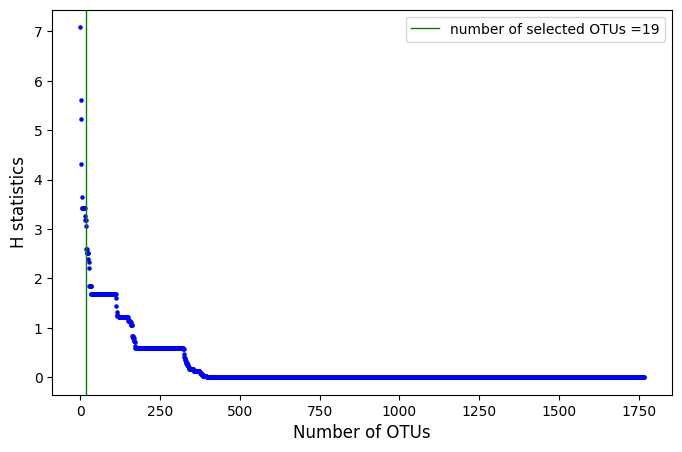

In [6]:
# select the OTUs

selectedresult=FS.SelectMicro_fun(df,duration_label)
    
selectedresult.keys()

In [7]:
selectedOTU_index_list = selectedresult['selected_indices']
selectedASV_list = selectedresult['selected_columnames']
X_FS_list = selectedresult['selected_data']
data = selectedresult['relative_abundance_data']


### 4. Model (default RF or SVM) 
The SVM model is always predicting one class, consider to fine tune the model's parameters.

In [8]:

targetLabel=duration_label
print("The response variable and its counts are:")
print(targetLabel.value_counts())

X_FS = X_FS_list


The response variable and its counts are:
Duration
Perennial    37
Annual       22
Name: count, dtype: int64


In [9]:
print(f'The shape of the original dataset is ',np.shape(data))
print(f'The shape of the SelectMicro dataset is ',np.shape(X_FS))


The shape of the original dataset is  (59, 1768)
The shape of the SelectMicro dataset is  (59, 19)


In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(targetLabel)  

In [11]:
y

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1])

In [19]:
duration_label

0        Annual
1     Perennial
2     Perennial
3        Annual
4     Perennial
5     Perennial
6     Perennial
7        Annual
8        Annual
9     Perennial
10    Perennial
11    Perennial
12       Annual
13    Perennial
14       Annual
15       Annual
16    Perennial
17       Annual
18    Perennial
19    Perennial
20    Perennial
21       Annual
22    Perennial
23       Annual
24    Perennial
25       Annual
26    Perennial
27       Annual
28       Annual
29    Perennial
30    Perennial
31       Annual
32    Perennial
33    Perennial
34    Perennial
35    Perennial
36       Annual
37       Annual
38    Perennial
39    Perennial
40       Annual
41    Perennial
42    Perennial
43       Annual
44    Perennial
45    Perennial
46    Perennial
47       Annual
48       Annual
49       Annual
50    Perennial
51    Perennial
52    Perennial
53    Perennial
54    Perennial
55    Perennial
56       Annual
57    Perennial
58    Perennial
Name: Duration, dtype: object

1.0
0.8
1.0
0.53125
0.75


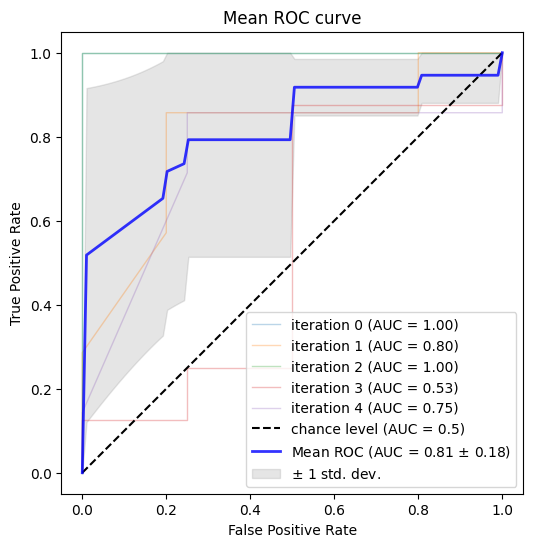

In [13]:
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from imblearn.over_sampling import SMOTE
# Split the dataset into training and testing sets (80% train, 20% test)
# Set up 5-fold cross-validation
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=777)

# performance reports
accuracy_results = list()
f1_results = list()
precision_results = list()
recall_results = list()
roc_auc_results = list()

# preparation for ROC curve
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# preparation for SHAP
enriched_all = pd.DataFrame(selectedASV_list, columns = ['Taxa'])
shap_values_all = np.empty((0, X_FS.shape[1],2))
test_sets_ix = []
idx = 0

fig, ax = plt.subplots(figsize=(6, 6))
X_FS_df = pd.DataFrame(X_FS,columns=selectedASV_list)
for train_ix, test_ix in cv_outer.split(X_FS_df,y):
# split data
    X_train, X_test = X_FS_df.iloc[train_ix], X_FS_df.iloc[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]


    clf = RandomForestClassifier(n_jobs=5, random_state=777)
    
    sm = SMOTE(k_neighbors=5, random_state=777)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)
    y_prob1 = y_prob[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    #mcc = metric.mcc_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    roc_auc = roc_auc_score(y_test, y_prob1)
    print(roc_auc)
    
    # store the result
    accuracy_results.append(accuracy)
    f1_results.append(f1)
    roc_auc_results.append(roc_auc)
    
    # ROC curve
    viz = RocCurveDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        name=f"iteration {idx}",
        alpha=0.3,
        lw=1,ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    
    # SHAP values
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_test)
    shap_obj = explainer(X_test)
    shap_values_all = np.concatenate((shap_values_all, shap_values), axis=0) 
    test_sets_ix.append(test_ix)
    
    high_index = pd.DataFrame(shap_obj.data, columns=shap_obj.feature_names, index=X_test.index).idxmax()# finds the feature's index with the highest value for each sample.
    shap_1 = pd.DataFrame(shap_values[:,:,1], columns=shap_obj.feature_names, index=X_test.index)
    
    enriched = list()
    
    for v, i in high_index.items():
        sv = shap_1[v].loc[i]
        if sv<0:
            sv = "Level 0"
        else:
            sv = "Level 1"
        enriched.append(
            {
                'Taxa': v,
                'enriched': sv
            }
        )
    enriched = pd.DataFrame(enriched)
    enriched.rename(columns={'enriched': 'enriched{}'.format(idx+1)}, inplace=True)
    enriched_all = enriched_all.merge(enriched, on='Taxa', how='outer')

    idx += 1
# continue ROC
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve",
)
ax.axis("square")
ax.legend(loc="lower right")
#plt.show()


    

# sort x based on the test dataset index
test_sets_ix = np.concatenate(test_sets_ix)
X_test = pd.DataFrame(X_FS[test_sets_ix])
X_test.columns = selectedASV_list



In [14]:
print('Accuracy: %.3f (%.3f), F1: %.3f (%.3f),AUC:%.3f (%.3f)' % (np.mean(accuracy_results), np.std(accuracy_results), np.mean(f1_results), np.std(f1_results),np.mean(roc_auc_results), np.std(roc_auc_results)))

Accuracy: 0.761 (0.128), F1: 0.833 (0.077),AUC:0.816 (0.175)


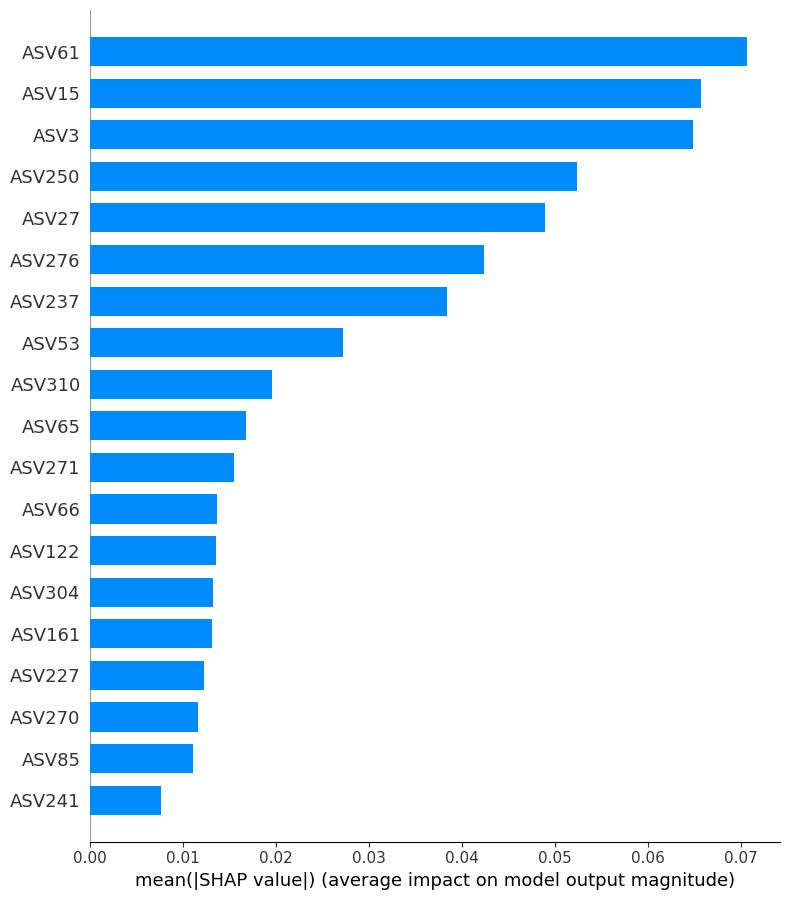

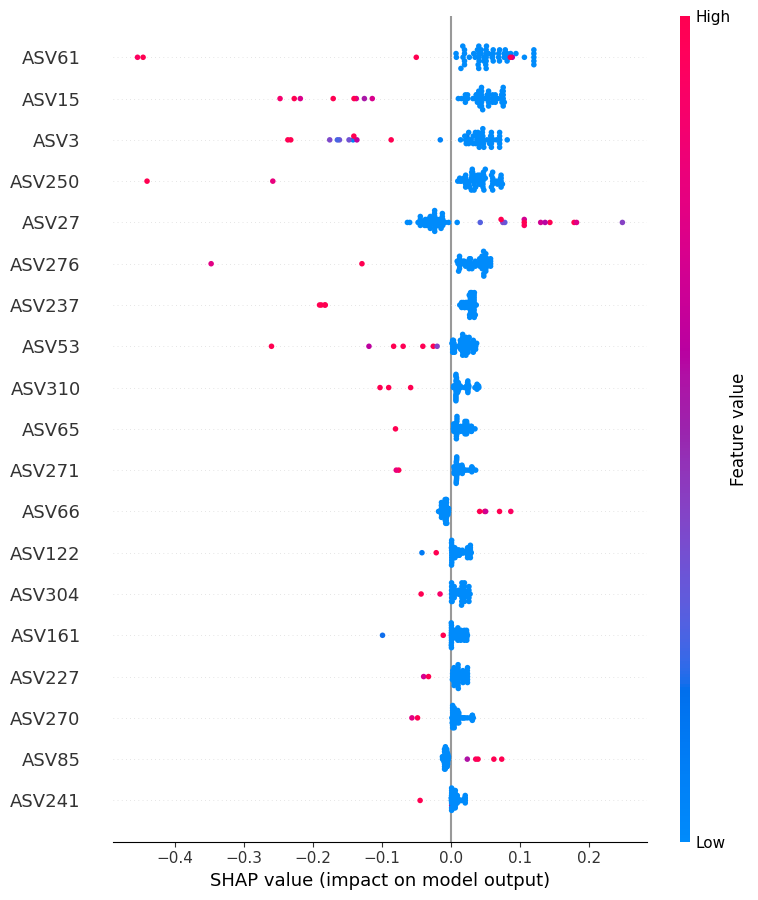

In [15]:
shap_1_all = shap_values_all[:,:,1]


shap.summary_plot(shap_1_all, X_test, plot_type="bar")

shap.summary_plot(shap_1_all, X_test)

In [16]:
# SHAP feature importances
mean_shap_feature_values = pd.DataFrame(shap_1_all, columns=selectedASV_list).abs().mean(axis=0).sort_values(ascending=False)
mean_shap_feature_values.index.name = 'features'
mean_shap_feature_values.name = 'mean_shap'
mean_shap_feature_values = mean_shap_feature_values.reset_index()
#mean_shap_feature_values.to_csv('data/SHAP_feature_importance_' + rank + '.csv', index=False)


In [17]:
enriched_all

,Taxa,enriched1,enriched2,enriched3,enriched4,enriched5
0,ASV237,Level 0,Level 0,Level 0,Level 1,Level 0
1,ASV15,Level 0,Level 0,Level 1,Level 0,Level 0
2,ASV310,Level 0,Level 1,Level 0,Level 1,Level 0
3,ASV61,Level 1,Level 0,Level 0,Level 0,Level 1
4,ASV53,Level 0,Level 0,Level 0,Level 0,Level 0
5,ASV65,Level 1,Level 1,Level 0,Level 1,Level 1
6,ASV122,Level 0,Level 1,Level 0,Level 1,Level 1
7,ASV161,Level 0,Level 1,Level 0,Level 1,Level 1
8,ASV227,Level 1,Level 0,Level 0,Level 1,Level 1
9,ASV241,Level 1,Level 1,Level 0,Level 1,Level 1


In [18]:
print(enriched)

      Taxa enriched5
0   ASV237   Level 0
1    ASV15   Level 0
2   ASV310   Level 0
3    ASV61   Level 1
4    ASV53   Level 0
5    ASV65   Level 1
6   ASV122   Level 1
7   ASV161   Level 1
8   ASV227   Level 1
9   ASV241   Level 1
10  ASV250   Level 0
11  ASV270   Level 1
12  ASV271   Level 1
13  ASV276   Level 0
14  ASV304   Level 1
15    ASV3   Level 0
16   ASV66   Level 1
17   ASV85   Level 1
18   ASV27   Level 1
